In [5]:
import numpy as np
np.bool = np.bool_
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mt
import matplotlib.pyplot as plt
import MDAnalysis as mda
import sys
sys.path.append('../../0_python_modules/')
import msm_analysis as ana
import idp_analysis as idp

In [6]:
n_clus = np.array([20, 30, 50, 70, 100, 150, 250, 350, 500, 700, 1000, 1500])
msm_lags = np.arange(5,70+1,5)
n_pcca = np.array([2, 3, 4, 5, 6])

In [7]:
def get_msm_labels(diff, nc, ml, npc):
    out = []
    for i in range(len(nc)):
        for j in range(len(ml)):
            for k in range(len(npc)):
                out.append([ nc[i], ml[j], npc[k], diff[i,j,k] ])
    return np.array(out)

In [109]:
def get_frames(mdis, dtrj, stds, 
               microstate='large',):
    frames = []
    for a,macro in enumerate(mdis):
        if microstate=='large':
            micro = macro[ stds[macro].argmax() ]
        else:
            micro = macro[ stds[macro].argmin() ]
            
        nframes = np.where(dtrj==micro)
        frames.append(nframes[0])
        
    return frames

def write_frames(pdb, trajs, idata,
                 fid, nconfs=10, otype='random', sel='all', sel2='all',
                ofmt='pdb', opath='./', oname='frame'):
    
    uni = mda.Universe(f'{pdb}', f'{trajs}')
    
    dd = idata[fid]
    
    if otype=='random':
        np.random.seed(0)
        oframes = np.random.choice(fid, nconfs)
    elif otype == 'min':
        oframes = fid[dd.argsort()[:nconfs]]
    elif otype == 'max':
        oframes = fid[dd.argsort()[::-1][:nconfs]]
    elif otype == 'variable':
        oframes = fid[dd.argsort()[::int(len(fid)/nconfs)][:nconfs]]
    else:
        raise ValueError(f'{otype} not in [random, variable, min, max]')
        
    for a,i in enumerate(oframes):
        uni.trajectory[i]
        aa = uni.select_atoms(f'{sel}')
        aa = aa.translate(-uni.select_atoms(sel2).center_of_mass())
        aa.write(f'{opath}{oname}{a}.{ofmt}')

In [8]:
colors = np.array(['salmon', 'dodgerblue', 'teal', 'limegreen', 'sienna', 'violet'])
cmaps = [mt.colors.LinearSegmentedColormap.from_list('', colors[:i], N=i) for i in range(2, 7)]

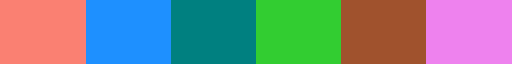

In [16]:
cmaps[4]

In [95]:
trajs = '../../1_datasets/idp_rg/pnas2018b-asyn-a99SBdisp-extended-protein-combined.xtc'
pdb = '../../1_datasets/idp_rg/DESRES-Trajectory_pnas2018b-asyn-a99SBdisp-extended-protein.pdb'

In [18]:
idata1 = np.loadtxt('../../1_datasets/idp_rg/rg_system.xvg', comments=['@','#'])[:,1]
idata2 = np.loadtxt('../../1_datasets/idp_rg/dist_ca_10-130.xvg', comments=['@','#'])[:,1]

durf = np.load('urf/saved_fdiffs/cmean_strict.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    for pc in n_pcca:
        d2 = d1[d1[:,2]==pc]
        print(i, pc, np.round(d2[d2[:,3].argmax()], 2) )
    print('\n')

In [51]:
durf = np.load('urf/saved_fdiffs/cmean_strict.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==2]
    print(i, np.round(d1[d1[:,3].argmax()], 2) )

0 [20.  5.  2. 34.]
1 [30.  5.  2. 26.]
2 [20.  5.  2. 27.]
3 [20.  5.  2. 29.]
4 [20.  5.  2. 32.]


In [52]:
durf = np.load('urf/saved_dbi/dbi.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==2]
    print(i, np.round(d1[d1[:,3].argmax()], 2) )

0 [100.     5.     2.     1.99]
1 [70.   65.    2.    2.03]
2 [700.    60.     2.     2.01]
3 [70.    5.    2.    1.98]
4 [50.    5.    2.    1.94]


## i=0, cl=20, ml=5, pc=2

In [53]:
i=0
cl = 20
ml = 5
pc = 2

In [54]:
tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 1,  7, 11, 14]),
 array([ 0,  2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 15, 16, 17, 18, 19])]

In [57]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


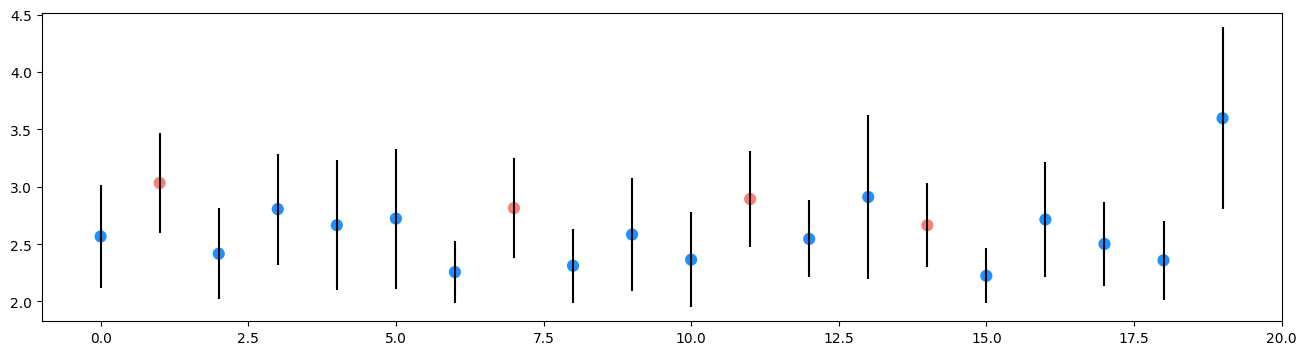

In [58]:
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

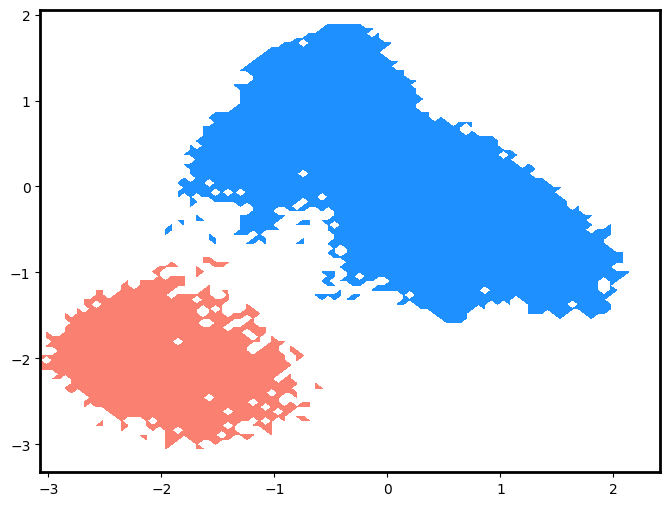

In [61]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [62]:
for a, k in enumerate(mdis): print(a,model.pi[k].sum())

0 0.08468093303585936
1 0.9153190669641404


In [63]:
fr = ml * 10 * 10**(-6)
for k in range(pc-1):
    for j in range(k+1,pc):
        print(k,j,model.mfpt(mdis[k], mdis[j])*fr, model.mfpt(mdis[j], mdis[k])*fr)

0 1 0.0652219173603358 0.7101179623617199


In [65]:
mdtrj = ana.get_mdtrj([dtrj], mdis, output_type='trj')
mmodel = msm.estimate_markov_model(mdtrj, lag=ml)

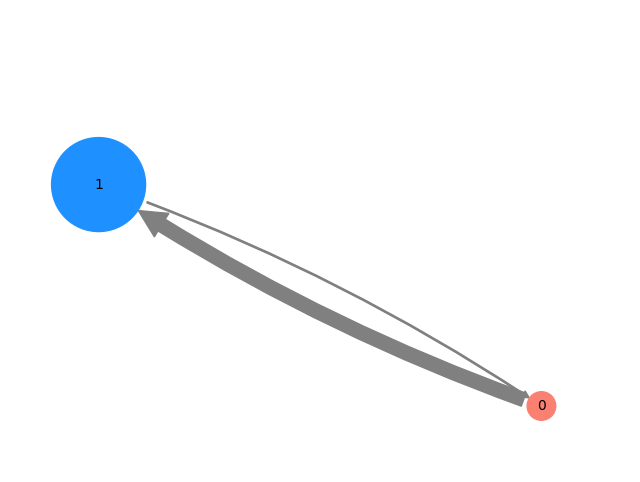

In [70]:
fig,ax=plt.subplots(1, figsize=(8,6))
mplt.plot_markov_model(mmodel, 
                       pos=np.array([[2,0],[0,1]]), 
                       state_colors=colors[:pc],
                       arrow_labels=None, arrow_scale=1.4, ax=ax
                      )
plt.savefig(f'plots/markov_model_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

In [83]:
dd=get_frames(mdis, dtrj, stds)

In [111]:
for a,i in enumerate(dd):
    write_frames(pdb, trajs, idata1,
                fid=i, nconfs=20, otype='max',
                 opath='saved_MSM2/', oname=f's{a}_')

/home/msahil/softwares/miniconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


## i=3, cl=70, ml=5, pc=2

In [112]:
i=3
cl = 70
ml = 5
pc = 2

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 1,  8, 13, 14, 29, 38, 39, 44, 45, 54, 58, 65, 67]),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40,
        41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61,
        62, 63, 64, 66, 68, 69])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


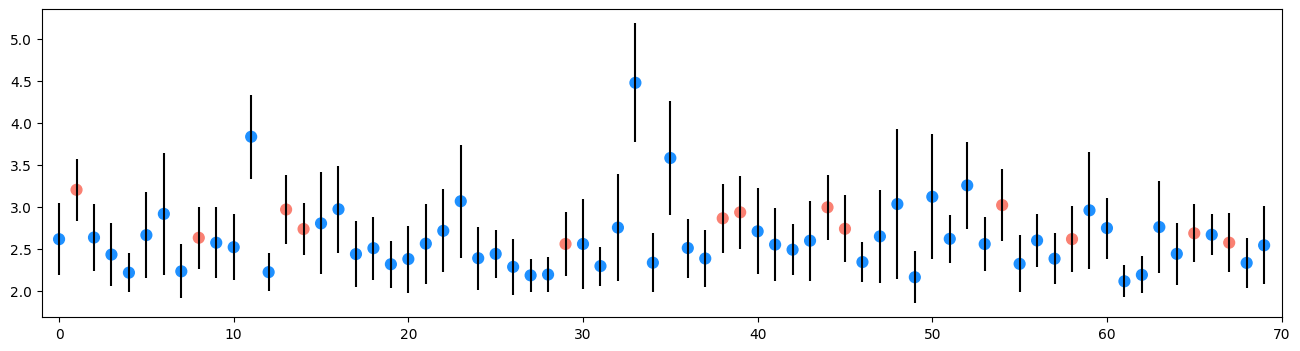

In [115]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

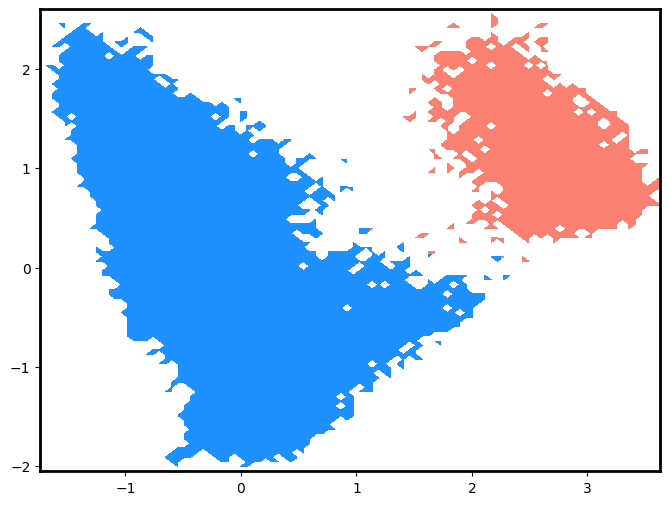

In [116]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

## i=0, cl=100, ml=5, pc=2

In [117]:
i=0
cl = 100
ml = 5
pc = 2

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 1,  8, 14, 15, 25, 26, 39, 46, 52, 54, 56, 58, 59, 60, 85, 86, 96,
        98]),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40,
        41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 55, 57, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


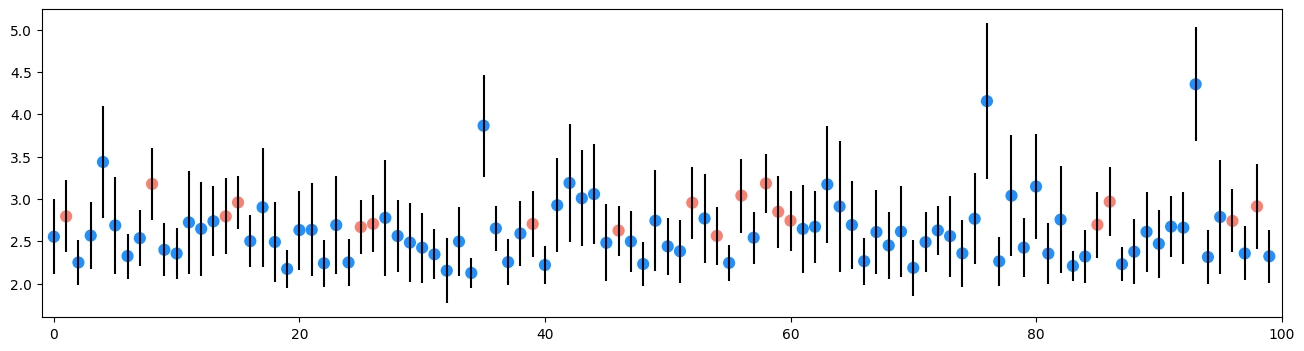

In [118]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()
mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

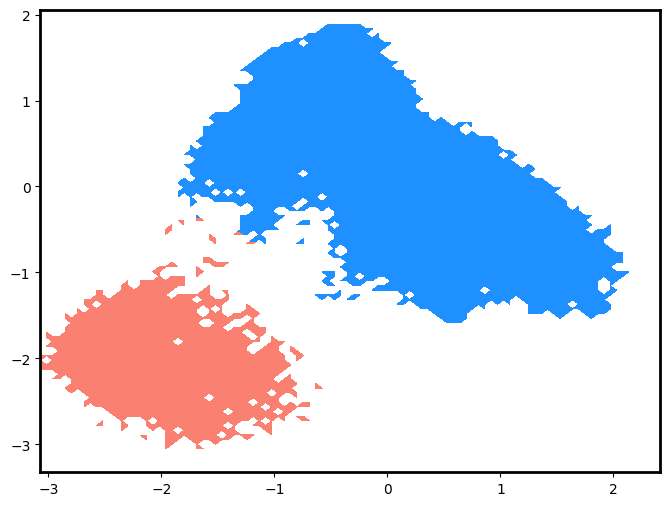

In [119]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()